In [1]:
import os
from datetime import datetime, timedelta
import pandas as pd
import quandl as qd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

In [2]:
key = os.environ.get('Quandl_API_Key')
qd.ApiConfig.api_key = key

In [3]:
# "RATEINF/INFLATION_USA" "MULTPL/SP500_PE_RATIO_MONTH" "MULTPL/SP500_EARNINGS_MONTH"

In [4]:
today = datetime.today().date()

# get the actual day number
today_day_num = today.strftime("%d")

In [5]:
start_date = "1970-01-01"

end_date = today - timedelta(days=int(today_day_num) - 1) #Establish the end date as the first date of the current month

inflation_data = qd.get("RATEINF/INFLATION_USA", start_date = start_date, end_date = end_date)

pe_data = qd.get("MULTPL/SP500_PE_RATIO_MONTH", start_date = start_date, end_date = end_date)

In [6]:
df = pd.merge_asof(left=inflation_data, right=pe_data, right_index=True,left_index=True,direction='nearest') #Merge to the closest date since the days do not line up perfectly
df = df.rename(columns={'Value_x':'Inflation',
                        'Value_y':'S&P500_PE'})
df

,Inflation,S&P500_PE
Date,,
1970-01-31,6.180,15.35
1970-02-28,6.145,15.75
1970-03-31,5.817,15.37
1970-04-30,6.061,13.69
1970-05-31,6.044,13.69
...,...,...
2022-08-31,8.263,19.98
2022-09-30,8.202,18.12
2022-10-31,7.745,20.14


In [7]:
df.describe()

,Inflation,S&P500_PE
count,636.000000,636.000000
mean,4.037072,19.905582
std,2.964066,12.568160
min,-2.097000,6.790000
25%,2.087250,13.375000
50%,3.187500,18.135000
75%,5.047250,22.830000
max,14.756000,123.730000


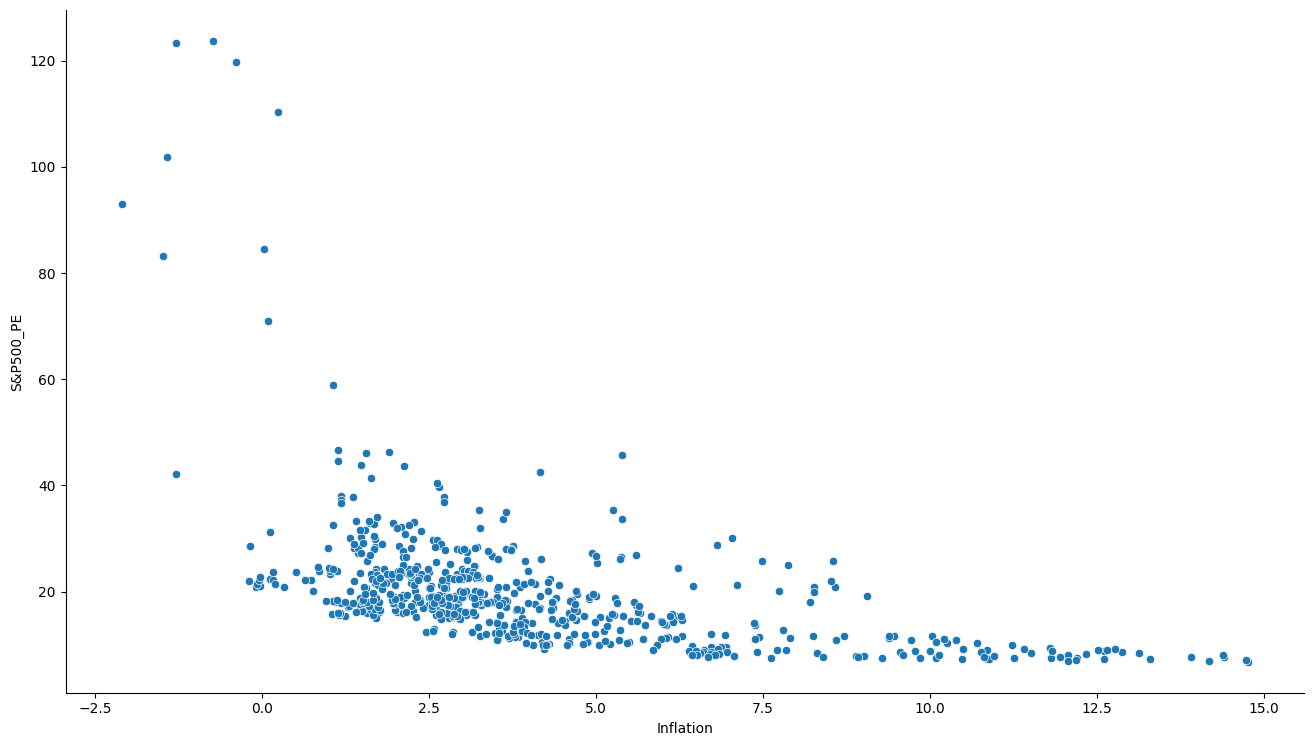

In [8]:
g = sns.relplot(x='Inflation', y='S&P500_PE', data=df)
g.fig.set_size_inches(15,8)

In [9]:
#Remove outliers in S&P 500

#upper_limit = df['S&P500_PE'].mean()+2*df['S&P500_PE'].std()
#lower_limit = df['S&P500_PE'].mean()-2*df['S&P500_PE'].std()

upper_limit = df['S&P500_PE'].quantile(0.95)

df = df[(df['S&P500_PE'] < upper_limit)]

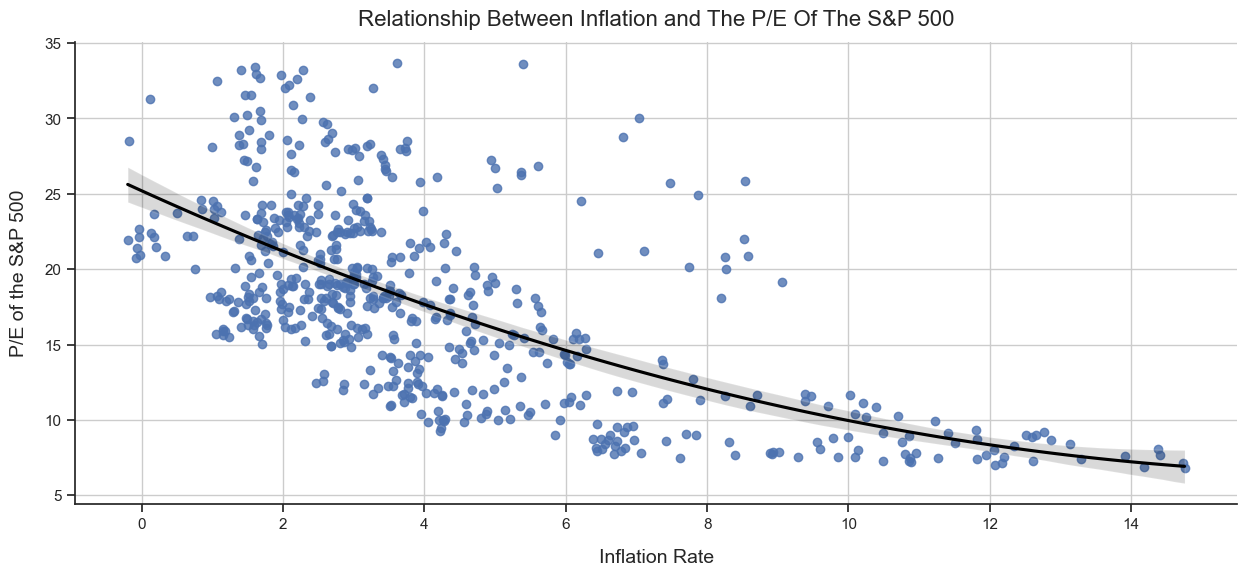

In [10]:
plt.figure(figsize=(15,6))
sns.set(style="ticks")
ax = sns.regplot(x='Inflation', y='S&P500_PE', data=df, order = 2, line_kws={"color":"black"})
sns.despine()
plt.xlabel("Inflation Rate", fontsize= 14, labelpad =12)
plt.ylabel("P/E of the S&P 500", fontsize= 14, labelpad =12)
plt.title("Relationship Between Inflation and The P/E Of The S&P 500", fontsize=16, pad= 12)
plt.grid();

In [11]:
X = df['Inflation']
y = df['S&P500_PE']

## Statsmodel Method

https://ostwalprasad.github.io/machine-learning/Polynomial-Regression-using-statsmodel.html

In [12]:
from sklearn.preprocessing import PolynomialFeatures
sm_poly = PolynomialFeatures(degree=2)
sm_poly_features = sm_poly.fit_transform(X.values.reshape(-1,1))

model = sm.OLS(y, sm_poly_features).fit()
ypred = model.predict(sm_poly_features) 

In [13]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              S&P500_PE   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     212.7
Date:                Tue, 07 Feb 2023   Prob (F-statistic):           1.43e-70
Time:                        11:36:13   Log-Likelihood:                -1811.0
No. Observations:                 604   AIC:                             3628.
Df Residuals:                     601   BIC:                             3641.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.1970      0.583     43.234      0.000      24.052      26.342
x1            -2.1240      0.234     -9.091      0.000      -2.583      -1.665
x2             0.0600      0.018      3.372      0.001       0.025       0.095
==============================================================================
Omnibus:                       61.527   Durbin-Watson:                   0.070
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               77.812
Skew:                           0.848   Prob(JB):                     1.27e-17
Kurtosis:                       3.461   Cond. No.                         147.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
model.params

const    25.197032
x1       -2.123970
x2        0.060001
dtype: float64

In [15]:
intercept = round(model.params[0],2)
x1 = round(model.params[1],2)
x2 = round(model.params[2],2)

In [33]:
user_input = 6.45
test = sm_poly.fit_transform(np.array(user_input).reshape(-1,1))
new_result = model.predict(test)
new_result

array([13.99363152])

In [34]:
round(new_result[0],2)

13.99

In [35]:
prediction_intervals = model.get_prediction(test)
intervals = prediction_intervals.summary_frame(alpha=0.05)

In [36]:
intervals

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,13.993632,0.341327,13.323292,14.663971,4.416749,23.570514


In [37]:
print(f"The point estimate of the user input is: {round(intervals['mean'][0],2)}")
print(f"The lower confidence interval is: {round(intervals['mean_ci_lower'][0],2)}")
print(f"The upper confidence interval is: {round(intervals['mean_ci_upper'][0],2)}")

The point estimate of the user input is: 13.99
The lower confidence interval is: 13.32
The upper confidence interval is: 14.66


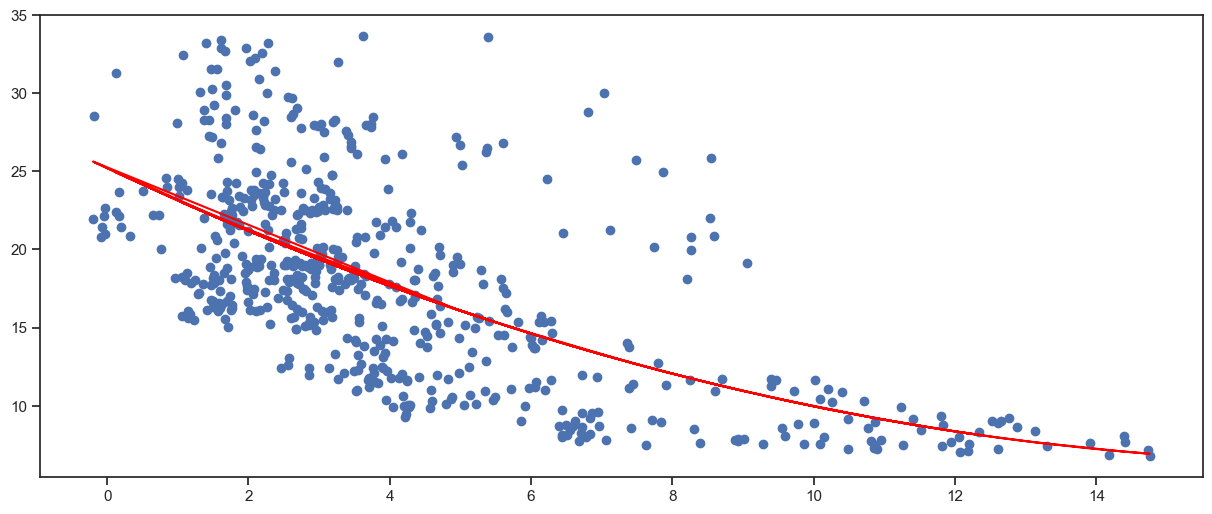

In [23]:
plt.figure(figsize=(15, 6))
plt.scatter(X, y)
plt.plot(X, ypred, c="red")
plt.show()